In [1]:
!pip install umap-learn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.8 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import tqdm
import umap
import seaborn as sns

In [3]:
%%capture
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.1307,), (0.3081,))  # Mean and std for MNIST
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=96, shuffle=True)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=96, shuffle=False)

In [4]:
class VAE(torch.nn.Module):
  def __init__(self, config):
    super(VAE, self).__init__()
    kernel_sizes = config['kernel_sizes']
    strides = config['strides']
    paddings = config['paddings']
    features = config['conv_features']
    linear_features = config['linear_features']

    enc_layers = []
    dec_layers = []
    l = len(features)
    for i in range(l-1):
      enc_layers.append(nn.Conv2d(kernel_size=kernel_sizes[i], stride=strides[i], padding=paddings[i], in_channels=features[i], out_channels=features[i+1]))
      if i == 0:
        dec_layers.append(nn.ConvTranspose2d(kernel_size=kernel_sizes[l-i-2], stride=strides[l-i-2], padding=paddings[l-i-2], in_channels=features[l-i-1], out_channels=features[l-i-2]))
      else:
        dec_layers.append(nn.ConvTranspose2d(kernel_size=kernel_sizes[l-i-2], stride=strides[l-i-2], padding=paddings[l-i-2], in_channels=features[l-i-1], out_channels=features[l-i-2]))
        enc_layers.append(nn.BatchNorm2d(features[i+1]))
      enc_layers.append(nn.LeakyReLU())
      if i != l-2:
        dec_layers.append(nn.BatchNorm2d(features[l-i-2]))
        dec_layers.append(nn.LeakyReLU())
      else:
        dec_layers.append(nn.Sigmoid())

    lin_encoder = [torch.nn.Linear(4 * 4 * features[-1], linear_features[0]), nn.LeakyReLU(), torch.nn.Linear(linear_features[0], linear_features[1] * 2)]
    lin_decoder = [torch.nn.Linear(linear_features[1], linear_features[0]), nn.LeakyReLU(), torch.nn.Linear(linear_features[0], 4 * 4 * features[-1])]

    self.encoder = torch.nn.Sequential(
        *enc_layers
    )
    self.lin_encode = torch.nn.Sequential(
        *lin_encoder
    )
    self.decoder = torch.nn.Sequential(
        *dec_layers
    )
    self.lin_decode = torch.nn.Sequential(
        *lin_decoder
    )

  def decode(self, x):
    x = self.lin_decode(x)
    x = x.view(x.size(0), -1, 4, 4)
    x = self.decoder(x)
    return x

  def forward(self, x):
    latent = self.encoder(x)
    latent = latent.view(latent.size(0), -1)
    latent = self.lin_encode(latent)
    mu, log_var = torch.chunk(latent, 2, dim=1)
    sigma = torch.exp(0.5 * log_var)

    x_reparam = mu + torch.randn_like(sigma) * sigma
    #x_reparam = mu + torch.randn_like(sigma)
    x_recon = self.lin_decode(x_reparam)
    x_recon = x_recon.view(x_recon.size(0), -1, 4, 4)
    x_recon = self.decoder(x_recon)
    return x_recon, mu, log_var

In [5]:
latent_shape = (10, 4, 4)
model = VAE({
    'kernel_sizes': [3, 4, 3, 4, 3],
    'strides': [1, 2, 1, 2, 2],
    'paddings': [1, 1, 1, 1, 1],
    'conv_features': [1, 32, 64, 64, 64, 32], # 28 -> 28 -> 14 -> 7 -> 4
    'linear_features' : [16, latent_shape[0]],
})
num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=3e-5)
loss_fn = F.l1_loss
palette = sns.color_palette("tab10", 10)
reducer = umap.UMAP(n_components=2, random_state=69)

In [6]:
def equalize(loss1, loss2):
  factor = loss1.cpu().detach().numpy() / loss2.cpu().detach().numpy()
  loss2 = loss2 * factor
  return loss1, loss2

# Training

In [ ]:
for epoch in range(50, num_epochs + 50):
    model.train()
    running_loss = 0.0
    _labels, inputs = None, None
    with tqdm.tqdm(enumerate(train_loader, 0), total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}") as pbar:
        for i, data in pbar:
            inputs = data[0].to(device)
            _labels = data[1]
            optimizer.zero_grad()

            x_reconstructed, mu, log_var = model(inputs)
            reconstruction_loss = loss_fn(x_reconstructed, inputs)
            x_reconstructed = F.sigmoid(x_reconstructed)
            dkl_loss = -0.5 * torch.mean(torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=[1]))
            #dkl_loss = 0.5 * torch.mean(torch.sum(mu.pow(2), dim=[1]))
            bound = 0.0 if epoch < 10 else 1.0
            beta = min(bound, epoch / num_epochs)
            # Linearly increasing KL weigth, notice we use Beta-VAE and use a small weight of DKL anyways.
            # But the beta here isn't used to minimize the entanglement, but to focus on the reconstruction.
            loss = reconstruction_loss + 1e-3 * beta * dkl_loss

            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            pbar.set_postfix(loss=loss.item(), refresh=True)

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch + 1} Average Loss: {avg_loss:.4f}")

    fig, axes = plt.subplots(1, 4, figsize=(28, 4))
    axes[0].imshow(model.decode(torch.randn(1, latent_shape[0], device=device)).squeeze().cpu().detach().numpy(), cmap='gray')
    axes[0].set_title('Generated Image')
    axes[1].imshow(inputs[0].squeeze().cpu().detach().numpy(), cmap='gray')
    axes[1].set_title('Original Image')
    axes[2].imshow(x_reconstructed[0].squeeze().cpu().detach().numpy(), cmap='gray')
    axes[2].set_title('Reconstructed Image')

    mu_2d = reducer.fit_transform(mu.cpu().detach().numpy().reshape(96, -1))
    labels_np = np.array(_labels)
    for label in range(10):
        axes[3].scatter(
            mu_2d[labels_np == label, 0], mu_2d[labels_np == label, 1],
            color=palette[label], label=str(label), alpha=0.7, edgecolors='k'
        )
    axes[3].set_title("Projection of UMAP")
    axes[3].legend(title="Digit Labels", loc="best", fontsize="small")
    axes[3].grid(True, linestyle="--", alpha=0.6)

    plt.show()

In [ ]:
torch.save(model, "vae_model.pth")

In [7]:
model = torch.load("vae_model.pth")

<ipython-input-7-daec60c98269>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("vae_model.pth")


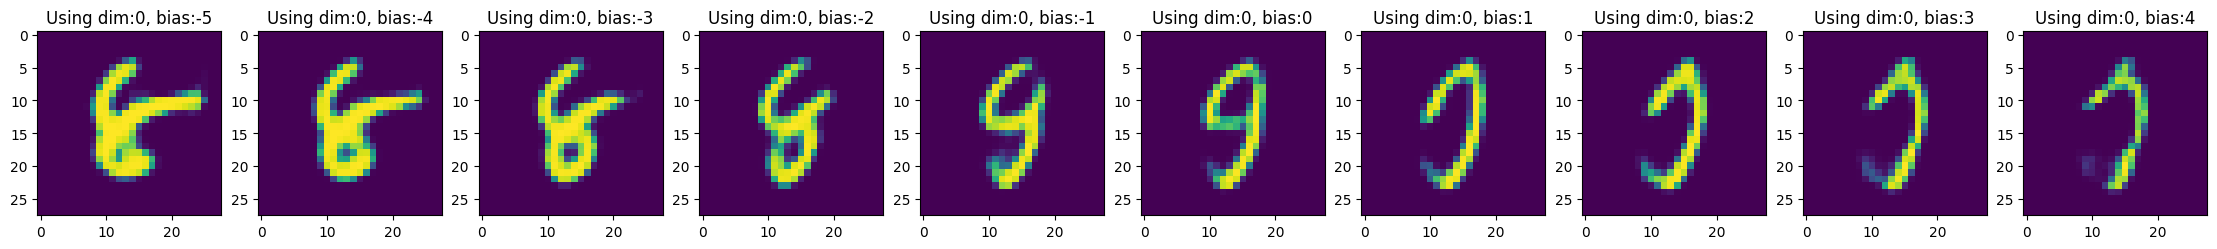

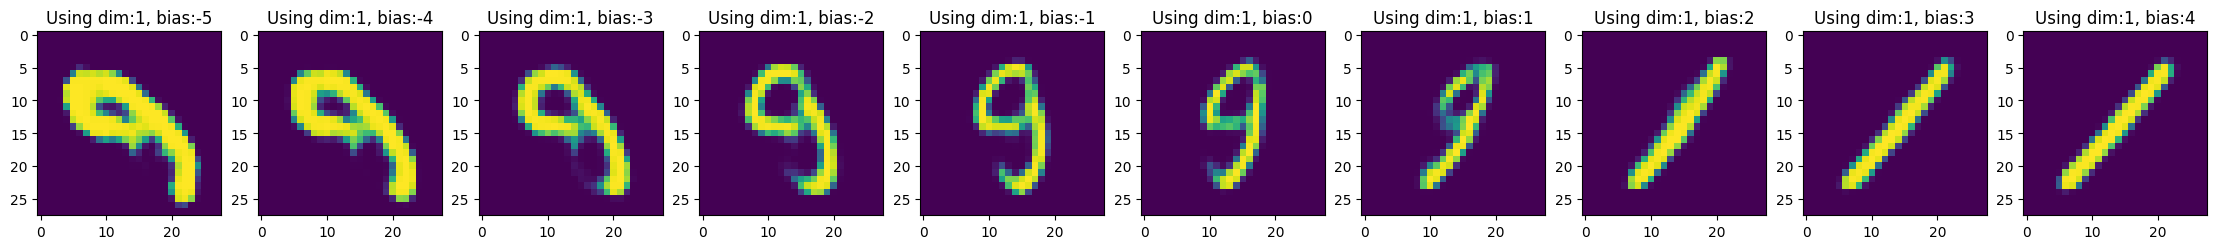

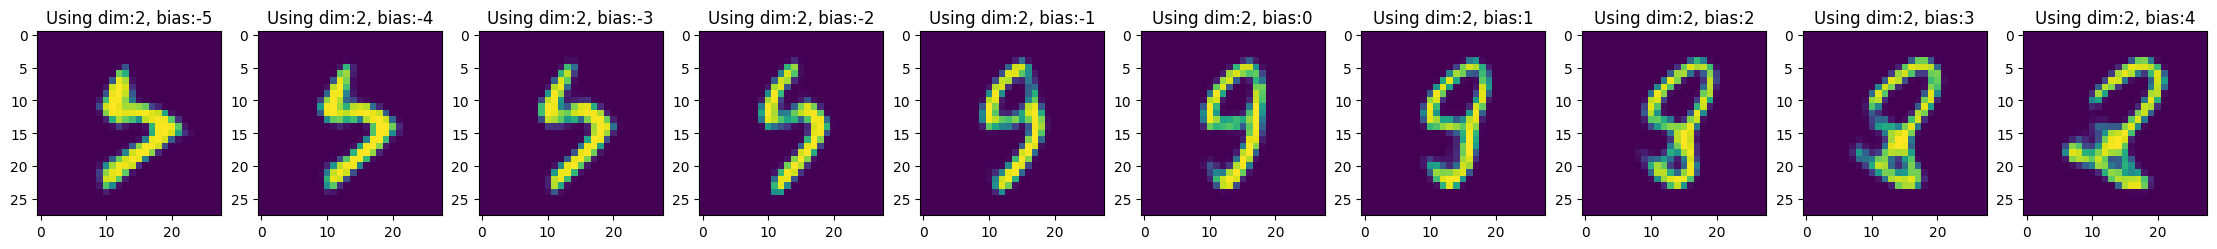

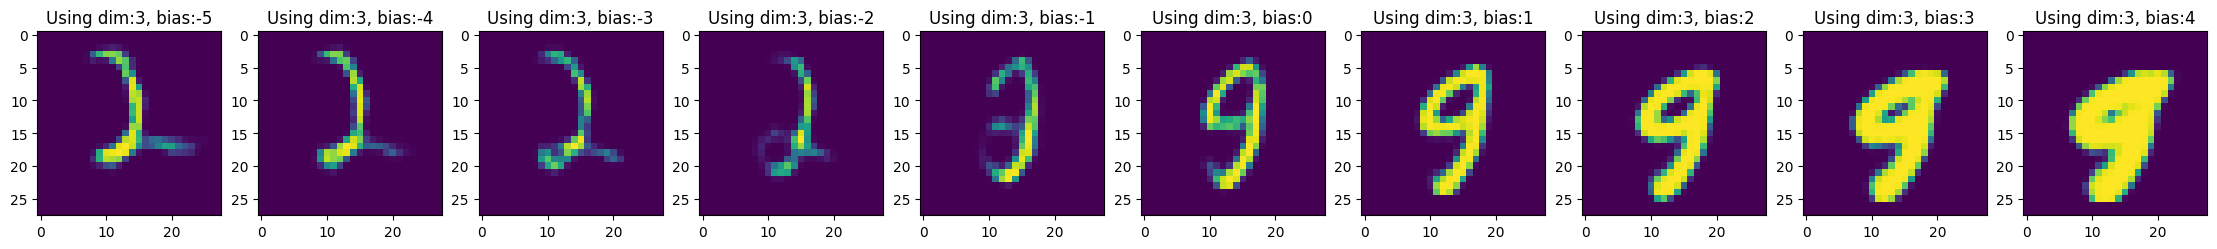

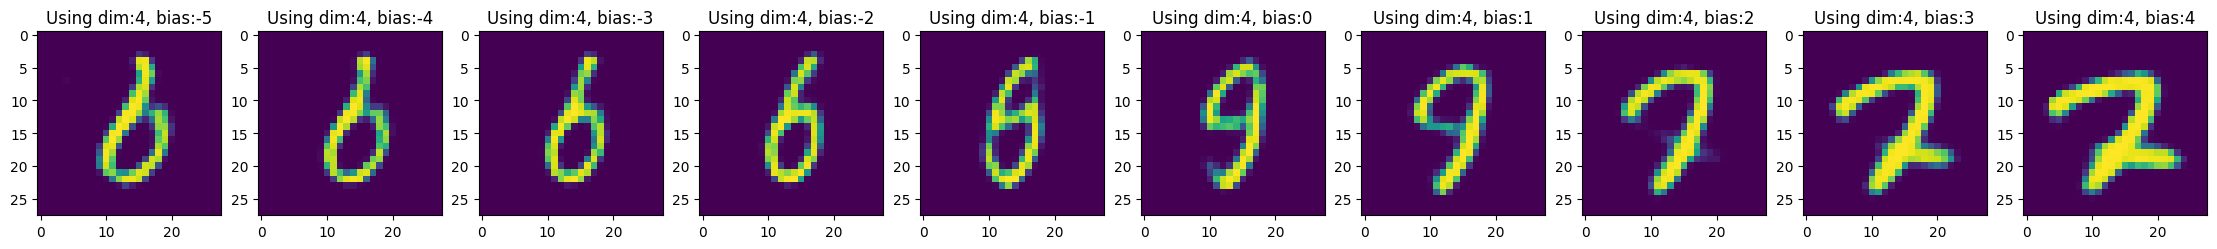

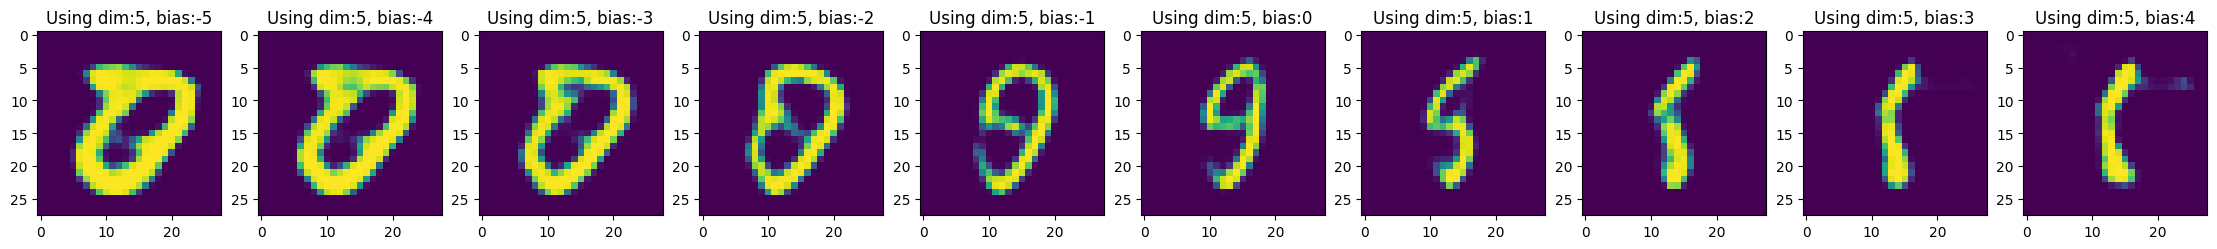

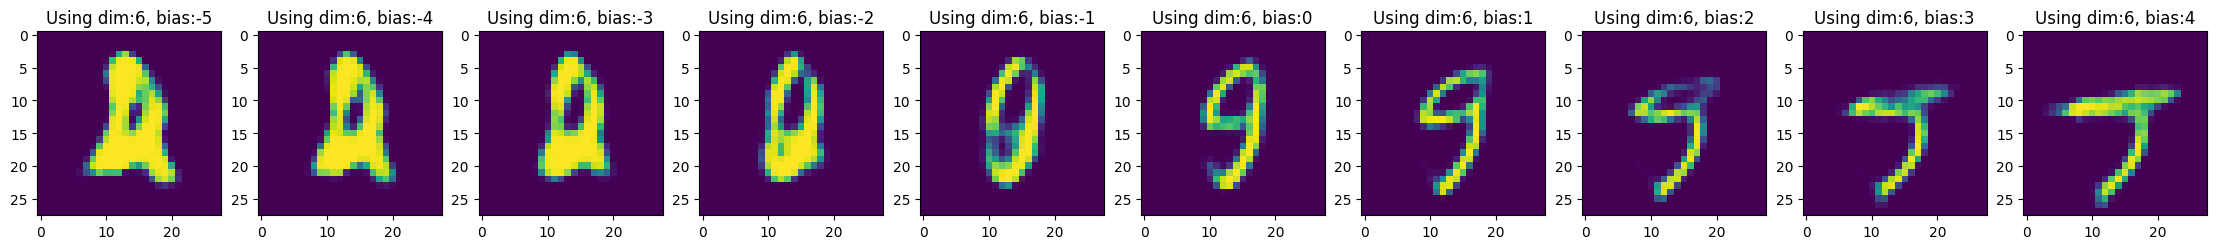

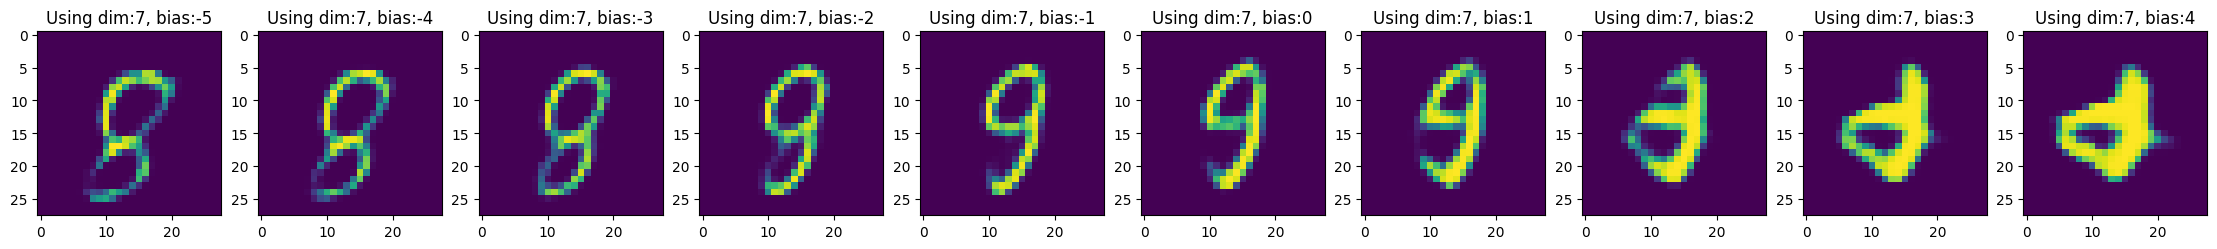

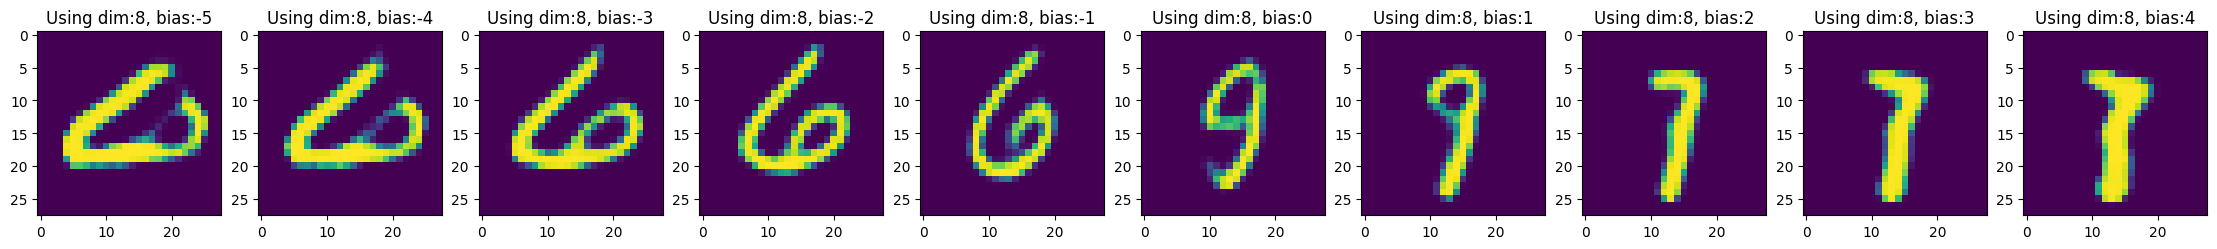

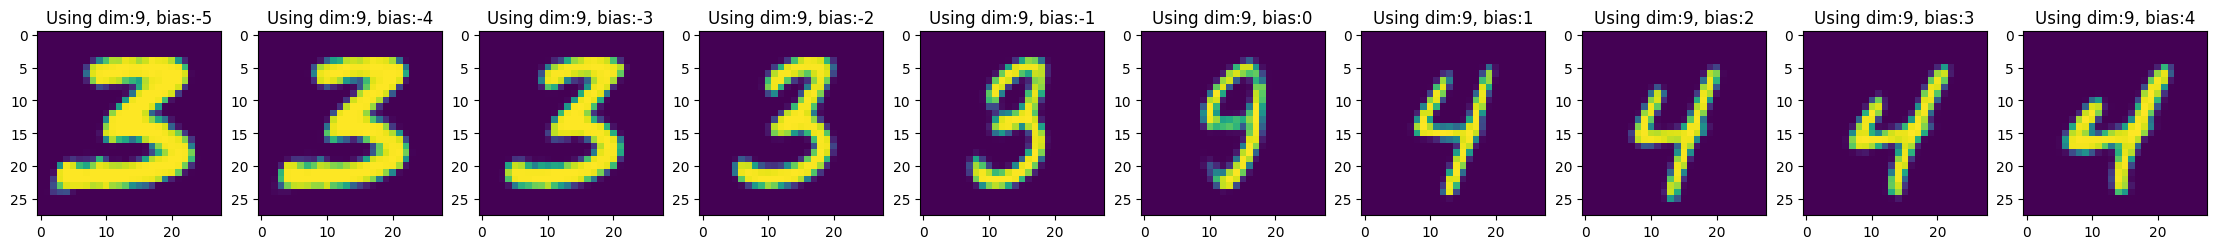

In [31]:
model.eval()

test_size = 10
zeros = torch.zeros(1, latent_shape[0], device=device)

for i in range(latent_shape[0]):
  fig, axes = plt.subplots(1, test_size, figsize=(28, 4))
  for k in range(test_size):
    zeros_t = zeros.clone()
    bias = k - test_size // 2
    zeros_t[0][i] = bias
    axes[k].set_title(f'Using dim:{i}, bias:{bias}')
    axes[k].imshow(model.decode(zeros_t).squeeze().cpu().detach().numpy())
  plt.show()

# Interpretation
By glossing over it, it looks like the dimensions control these:
Also dimensions it seems capture the classes and not specifically the properties
Which is somewhat expected since the classes are less in number then the properties, thus can fit better in the latent space.


0.   Spread of upper part
1.   Tilt 9<->1
2.   Closing gaps with lines 5<->8
3.   Thickness 2<->9
4.   Left or right orientation of symbol 6<->7
5.   Circularity 0<->1
6.   Density 2<->9
7.   Density and Horizontal closure 8<->3
8.   Vertical Closure 6<->1/7
9.   3<->4

It seems like 9 is the default choice.

# Original

In [ ]:
for epoch in range(50, num_epochs + 50):
    running_loss = 0.0
    _labels, inputs = None, None
    with tqdm.tqdm(enumerate(train_loader, 0), total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}") as pbar:
        for i, data in pbar:
            inputs = data[0].to(device)
            _labels = data[1]
            optimizer.zero_grad()

            x_reconstructed, mu, log_var = model(inputs)
            reconstruction_loss = loss_fn(x_reconstructed, inputs)
            x_reconstructed = F.sigmoid(x_reconstructed)
            dkl_loss = -0.5 * torch.mean(torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=[1]))
            #dkl_loss = 0.5 * torch.mean(torch.sum(mu.pow(2), dim=[1]))
            bound = 0.0 if epoch < 10 else 1.0
            beta = min(bound, epoch / num_epochs)
            # Linearly increasing KL weigth, notice we use Beta-VAE and use a small weight of DKL anyways.
            # But the beta here isn't used to minimize the entanglement, but to focus on the reconstruction.
            loss = reconstruction_loss + 1e-3 * beta * dkl_loss

            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            pbar.set_postfix(loss=loss.item(), refresh=True)

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch + 1} Average Loss: {avg_loss:.4f}")

    fig, axes = plt.subplots(1, 4, figsize=(28, 4))
    axes[0].imshow(model.decode(torch.randn(1, latent_shape[0], device=device)).squeeze().cpu().detach().numpy(), cmap='gray')
    axes[0].set_title('Generated Image')
    axes[1].imshow(inputs[0].squeeze().cpu().detach().numpy(), cmap='gray')
    axes[1].set_title('Original Image')
    axes[2].imshow(x_reconstructed[0].squeeze().cpu().detach().numpy(), cmap='gray')
    axes[2].set_title('Reconstructed Image')

    mu_2d = reducer.fit_transform(mu.cpu().detach().numpy().reshape(96, -1))
    labels_np = np.array(_labels)
    for label in range(10):
        axes[3].scatter(
            mu_2d[labels_np == label, 0], mu_2d[labels_np == label, 1],
            color=palette[label], label=str(label), alpha=0.7, edgecolors='k'
        )
    axes[3].set_title("Projection of UMAP")
    axes[3].legend(title="Digit Labels", loc="best", fontsize="small")
    axes[3].grid(True, linestyle="--", alpha=0.6)

    plt.show()